In [2]:
import setGPU

import tensorflow as tf

from efficientnet.tfkeras import EfficientNetB5 as net
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

import os, shutil
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

### Data reading varification of validity of samples and check the distribution of sample resolutions ###

In [3]:
data_path = '../data'
classes = ['Chickens', 'Cows']

""" delete temp directory created in case if that exists"""
if os.path.exists(os.path.join(data_path, 'data_split')):
    shutil.rmtree(os.path.join(data_path, 'data_split'))

In [4]:
""" check all the samples and store the size to visualize the distribution """
size_w = []
size_h = []
def verify_file(file_path):
    img = cv.imread(file_path)
    size_w.append(img.shape[0])
    size_h.append(img.shape[1])
    if img is None:
        print("image is not valid", file_path)

In [5]:
""" parse all the samples in both the classes """
for cls_name in os.listdir(data_path):
    cls_path = os.path.join(data_path, cls_name)
    for file_name in os.listdir(cls_path):
        file_path = os.path.join(cls_path, file_name)
        verify_file(file_path)

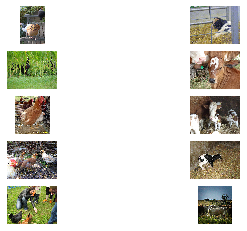

In [6]:
""" visualize a few samples here """
chicken_samples = os.listdir(os.path.join(data_path, classes[0]))
cow_samples = os.listdir(os.path.join(data_path, classes[1]))

num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    if cls == 'Chickens':
        idxs = np.random.choice(chicken_samples, samples_per_class, replace=False)
    else:
        idxs = np.random.choice(cow_samples, samples_per_class, replace=False)
        
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cv.cvtColor(cv.imread(os.path.join(data_path, cls, idx)), cv.COLOR_BGR2RGB))
        plt.axis('off')
        
plt.show()

(array([3.400e+01, 1.540e+02, 2.883e+03, 9.570e+02, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  92. ,  203.4,  314.8,  426.2,  537.6,  649. ,  760.4,  871.8,
         983.2, 1094.6, 1206. ]),
 <a list of 10 Patch objects>)

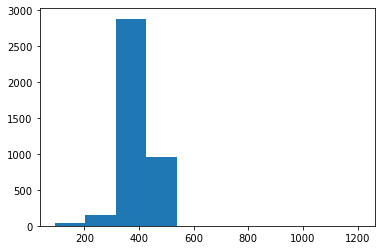

In [7]:
""" plot histogram wrt to widths """
plt.hist(size_w)

(array([3.400e+01, 6.980e+02, 3.292e+03, 5.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 125. ,  272.5,  420. ,  567.5,  715. ,  862.5, 1010. , 1157.5,
        1305. , 1452.5, 1600. ]),
 <a list of 10 Patch objects>)

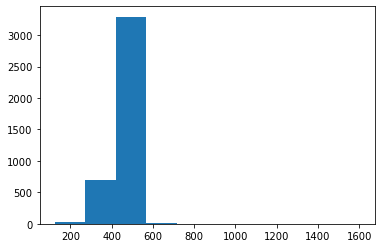

In [8]:
""" plot histogram wrt to height """
plt.hist(size_h)

### Data splitting as train, validation and test with 60%, 20% and 20% respectively ###

In [9]:
""" check the total no of samples in each class """
total_chicken_samples = len(chicken_samples)
total_cow_samples = len(cow_samples)
print(total_chicken_samples, total_cow_samples)

1980 2052


In [10]:
""" data split """
no_train_chicken_samples = int(0.6*total_chicken_samples)
no_valid_chicken_samples = int(0.2*total_chicken_samples)
no_test_chicken_samples = int(0.2*total_chicken_samples)
print(no_train_chicken_samples, no_valid_chicken_samples, no_test_chicken_samples)

1188 396 396


In [11]:
no_train_cow_samples = int(0.6*total_cow_samples)
no_valid_cow_samples = int(0.2*total_cow_samples)
no_test_cow_samples = int(0.2*total_cow_samples)
print(no_train_cow_samples, no_valid_cow_samples, no_test_cow_samples)

1231 410 410


In [12]:
def data_dir_creation(path):
    if not os.path.exists(path):
        os.makedirs(path)

    chicken_data_path = os.path.join(path, classes[0])
    if not os.path.exists(chicken_data_path):
        os.makedirs(chicken_data_path)

    cow_data_path = os.path.join(path, classes[1])
    if not os.path.exists(cow_data_path):
        os.makedirs(cow_data_path)

In [13]:
""" create train, validation and test folders respectively """

train_data_path = os.path.join(data_path, 'data_split', 'train')
data_dir_creation(train_data_path)

""" validation data directories creation """
valid_data_path = os.path.join(data_path, 'data_split', 'validation')
data_dir_creation(valid_data_path)

""" test data directories creation """
test_data_path = os.path.join(data_path, 'data_split', 'test')
data_dir_creation(test_data_path)

In [14]:
def copy_files_in_data_split(valid_samples, test_samples, samples, class_type):
    """ copy samples in valid calls type directory """
    for _ in range(valid_samples):
        ind = np.random.randint(0, len(samples))
        file_name = samples[ind]
        src_file_name = os.path.join(data_path, class_type, file_name)
        dst_file_name = os.path.join(valid_data_path, class_type, file_name)
        shutil.copyfile(src_file_name, dst_file_name)
        samples.pop(ind)
    
    """ copy samples in test class type directory"""
    for _ in range(test_samples):
        ind = np.random.randint(0, len(samples))
        file_name = samples[ind]
        src_file_name = os.path.join(data_path, class_type, file_name)
        dst_file_name = os.path.join(test_data_path, class_type, file_name)
        shutil.copyfile(src_file_name, dst_file_name)
        samples.pop(ind)

    """ copy samples in train class type directory """
    for ind in range(len(samples)):
        file_name = samples[ind]
        src_file_name = os.path.join(data_path, class_type, file_name)
        dst_file_name = os.path.join(train_data_path, class_type, file_name)
        shutil.copyfile(src_file_name, dst_file_name)    

In [15]:
""" copy the files from original paths to newly created paths """
copy_files_in_data_split(no_valid_chicken_samples, no_test_chicken_samples, chicken_samples, classes[0])
copy_files_in_data_split(no_valid_cow_samples, no_test_cow_samples, cow_samples, classes[1])

### Choose pre-trained model and apply transfer learning using imagenet weights ###

In [16]:
""" set a few parameters here """
width=height = 224
batch_size = 32
epochs = 100

In [17]:
""" Use EfficientNet as base as it is state of the art in classification """
conv_base = net(weights='imagenet', include_top=False, input_shape=(height, width, 3))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
""" add classification head here on top of conv base"""
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.GlobalAveragePooling2D(name='gap'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='fc_out'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 7, 7, 2048)        28513520  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 2049      
Total params: 28,515,569
Trainable params: 28,342,833
Non-trainable params: 172,736
_________________________________________________________________


In [19]:
""" freeze all the trainable parameters of conv base and check the paramters difference before and after """
conv_base.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 7, 7, 2048)        28513520  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 2049      
Total params: 28,515,569
Trainable params: 2,049
Non-trainable params: 28,513,520
_________________________________________________________________


In [20]:
""" data generator and loading data with data  augmentation in place """
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",)
valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_datagen = train_gen.flow_from_directory(train_data_path, target_size=(height, width), class_mode='binary', batch_size=batch_size)
valid_datagen = valid_gen.flow_from_directory(valid_data_path, target_size=(height, width), class_mode='binary', batch_size=batch_size)

Found 2420 images belonging to 2 classes.
Found 806 images belonging to 2 classes.


In [21]:
""" compile and early stop """
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['acc'])

es_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
""" trigger training here and save the model """
history = model.fit_generator(train_datagen, steps_per_epoch=int(train_datagen.n//batch_size), 
                              epochs=epochs, validation_data=valid_datagen, validation_steps=int(valid_datagen.n//batch_size), 
                              use_multiprocessing=True, workers=16, callbacks=[es_cb])

model.save("../model/saved_model.h5")

Epoch 1/100
75/75 [==============================] - 21s 274ms/step - loss: 0.6823 - acc: 0.5570 - val_loss: 0.6231 - val_acc: 0.7212
Epoch 2/100
75/75 [==============================] - 15s 194ms/step - loss: 0.6279 - acc: 0.6960 - val_loss: 0.5295 - val_acc: 0.8637
Epoch 3/100
75/75 [==============================] - 14s 188ms/step - loss: 0.5769 - acc: 0.7802 - val_loss: 0.4521 - val_acc: 0.9350
Epoch 4/100
75/75 [==============================] - 14s 191ms/step - loss: 0.5450 - acc: 0.8070 - val_loss: 0.3921 - val_acc: 0.9625
Epoch 5/100
75/75 [==============================] - 15s 194ms/step - loss: 0.5125 - acc: 0.8342 - val_loss: 0.3430 - val_acc: 0.9737
Epoch 6/100
75/75 [==============================] - 14s 191ms/step - loss: 0.4824 - acc: 0.8622 - val_loss: 0.3045 - val_acc: 0.9787
Epoch 7/100
75/75 [==============================] - 14s 192ms/step - loss: 0.4480 - acc: 0.8861 - val_loss: 0.2730 - val_acc: 0.9825
Epoch 8/100
75/75 [==============================] - 14s 192ms

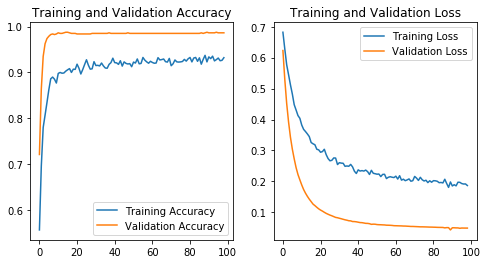

In [23]:
""" check the history of the model here """
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(99)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### load test data and evalutate the model ###

In [24]:
"""
create a numpy array with test images data and labels to evaluate and predict the results on test data
"""
def label_img(name):
    if name == classes[0]: return np.array([0])
    elif name == classes[1] : return np.array([1])
    
def load_test_data(path):
    test_data = []
    for clas in os.listdir(path):
        clas_path = os.path.join(path, clas)
        for file in os.listdir(clas_path):
            label = label_img(clas)

            file_path = os.path.join(clas_path, file)
            img = cv.imread(file_path)
            r_img = cv.resize(img, (height, width))
            c_img = cv.cvtColor(r_img, cv.COLOR_BGR2RGB)
            c_img = c_img*(1./255) #apply normalize that is applied in training
            test_data.append([np.array(c_img), label])

    shuffle(test_data)
    return test_data

(-0.5, 223.5, 223.5, -0.5)

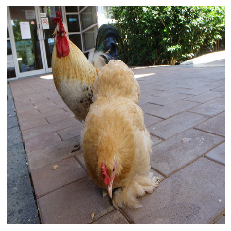

In [25]:
test_data = load_test_data(test_data_path)
plt.imshow(test_data[10][0])
plt.axis('off')

In [26]:
""" model evaluation """
testImages = np.array([i[0] for i in test_data])
testLabels = np.array([i[1] for i in test_data])
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

98.1389582157135


### Get predictions on the test data and show it's accuracy using confusion matrix ###

In [27]:
predictions = model.predict(testImages)
print(testLabels.shape, predictions.shape)

(806, 1) (806, 1)


In [28]:
cm_arr = confusion_matrix(testLabels, (predictions>0.5))
print(cm_arr)

[[387   9]
 [  6 404]]


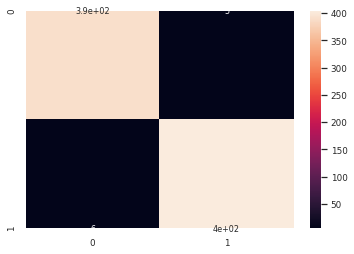

In [31]:
df_cm = pd.DataFrame(cm_arr, range(2), range(2))
sn.set(font_scale=0.8) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size

plt.show()